In [2]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline
from CDSK import dynamical_local_indexes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_T = Experiment(
    "ERA5", "t", "6H", "all", "JJA", -60, 70, 25, 85, 250, 'hourofyear', {'hourofyear': ('win', 24 * 10)}, None,
)
da_T = exp_T.da

In [4]:
from CDSK import compute_theta
da_s_coarsened = da_s.coarsen(lat=5, lon=5, boundary='trim').construct(
    lon=("x_coarse", "x_fine"), lat=("y_coarse", "y_fine")
)
X = da_s_coarsened.sel(time=da_s.time.dt.year == 2022).values
X = X.transpose(0, 2, 4, 1, 3)
X = X.reshape((X.shape[0], np.prod(X.shape[1:3]), np.prod(X.shape[3:])))
theta = np.zeros((X.shape[0], X.shape[2]))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, X_ in tqdm(enumerate(X.transpose(2, 0, 1)), total=X.shape[2]):
        theta[:, i] = compute_theta(
            X_, n_jobs=N_WORKERS
        ).squeeze()

100%|██████████| 1248/1248 [01:26<00:00, 14.39it/s]


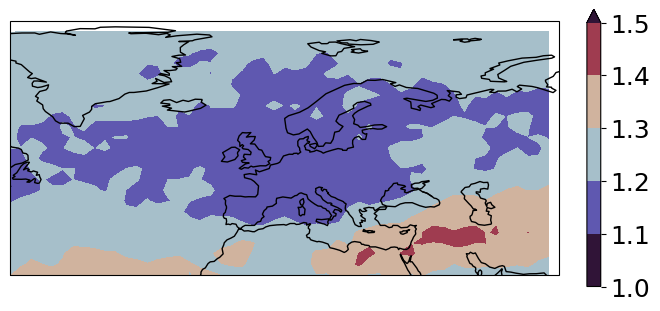

In [5]:
theta_da = da_s_coarsened[:, :, 0, :, 0].sel(time=da_s.time.dt.year == 2022).copy(data=theta.reshape((theta.shape[0], da_s_coarsened.shape[1], da_s_coarsened.shape[3]))).rename('theta')
clu = Clusterplot(1, 1, region=exp_s_low.region)
_ = clu.add_contourf([1 / theta_da.mean(dim='time')])